In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
import pcmdpy_gpu as ppy
import pandas as pd

plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'None'
%matplotlib inline

In [2]:
dark_mode = True

In [3]:
fig_dir = 'figures/japan/'
if dark_mode:
    plt.style.use('dark_background')


# Npix

In [93]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

In [246]:
g1 = ppy.galaxy.SSPSimple(np.array([0., -5., -1., 9.]), dmod=30.)
g2 = ppy.galaxy.SSPSimple(np.array([0., -5., 2., 9.]), dmod=30.)
g3 = ppy.galaxy.SSPSimple(np.array([0., -5., 4., 9.]), dmod=30.)
g4 = ppy.galaxy.SSPSimple(np.array([0., -5., 6., 9.]), dmod=30.)
g5 = ppy.galaxy.SSPSimple(np.array([0., -5., 8., 9.]), dmod=30.)

In [243]:
def make_im(gal, Nim=256):
    im = driv.simulate(gal, Nim, shot_noise=False)[1][0]
#     im -= im.min()
    im /= np.percentile(im.flatten(), 99.)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axis('off')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    norm = mpl.colors.Normalize(vmin=0, vmax=1.5)
    ax.imshow(im, cmap='Greys_r', aspect='equal', norm=norm)
    plt.tight_layout()
    return fig, ax

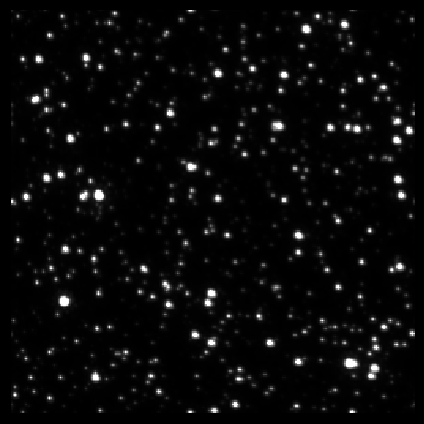

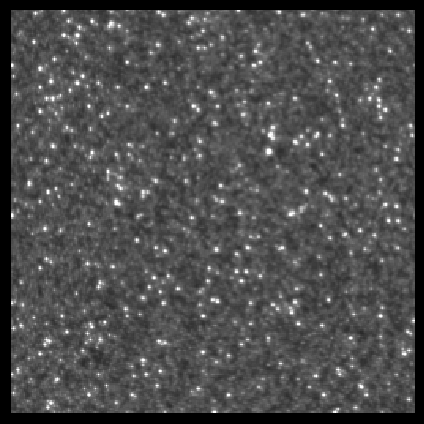

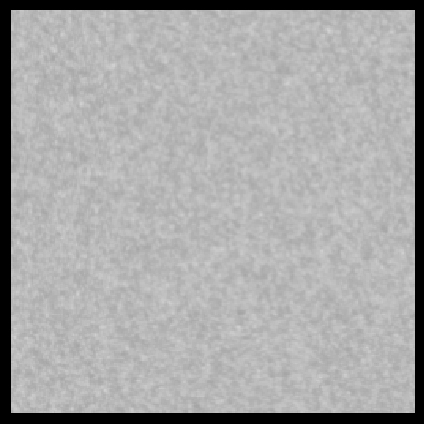

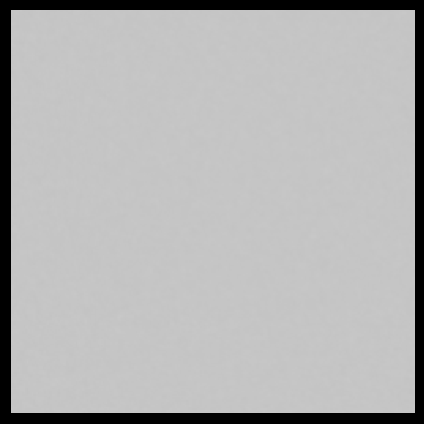

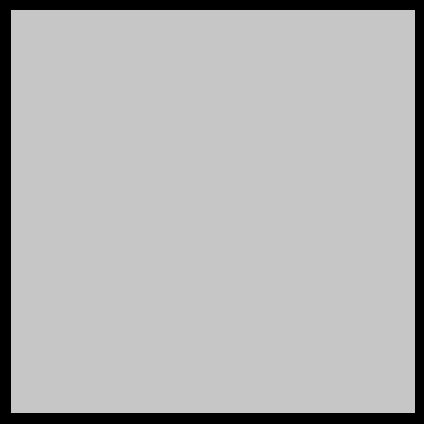

In [247]:
for i, g in enumerate([g1, g2, g3, g4, g5]):
    fig, ax = make_im(g)
    fig.savefig('figures/japan/Npix_{:d}.pdf'.format(i))

# Mock Tests

In [7]:
mock_model = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.3),
    ppy.dustmodels.FixedWidthLogNormDust(0.3),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.VariableDistance(),
    np.array([-0.2, -0.5, 3.25, 3.1, 29.2])
)
results_mock = ppy.plotting.ResultsPlotter('results/mock_tau_dmod.csv', true_model=mock_model, run_name='PCMDPy Mock Test')

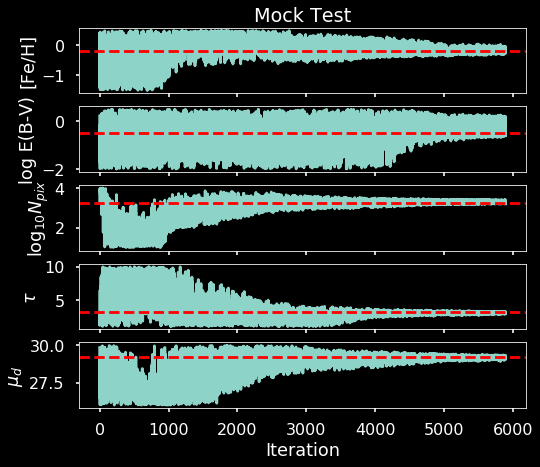

In [112]:
results_mock.plot_chains(chains_only=True);
plt.savefig(fig_dir + 'mock_chains.jpg')

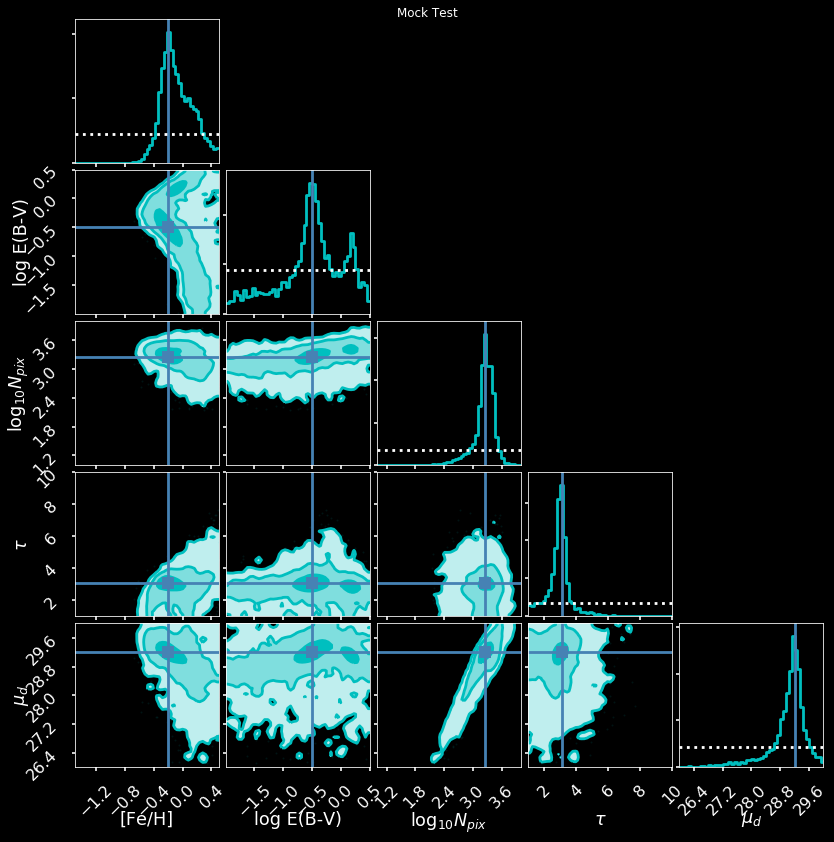

In [25]:
fig, axes = results_mock.plot_corner(color='c', burn=1500, weight=False, bins=50, smooth_frac=0.02);
plt.savefig(fig_dir + 'mock_corner.pdf')

# M31 Results

In [26]:
m31_bulge = np.loadtxt('../data/m31/pcmds/m31_r1.pcmd', unpack=True)
m31_disk = np.loadtxt('../data/m31/pcmds/m31_r2.pcmd', unpack=True)

In [116]:
res = {}
res['m31_bulge'] = ppy.plotting.ResultsPlotter('results/m31_taulm3_narrowF814W_r1.csv', run_name='M31 Bulge')
res['m31_disk'] = ppy.plotting.ResultsPlotter('results/m31_taulm3_narrowF814W_r2.csv', run_name='M31 Disk')

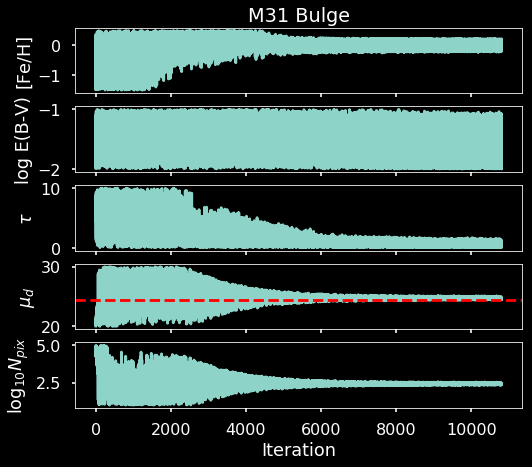

In [117]:
axes = res['m31_bulge'].plot_chains(chains_only=True);
axes[3].axhline(y=24.47, ls='--', color='r')
plt.savefig(fig_dir + 'm31_bulge_chains.jpg')

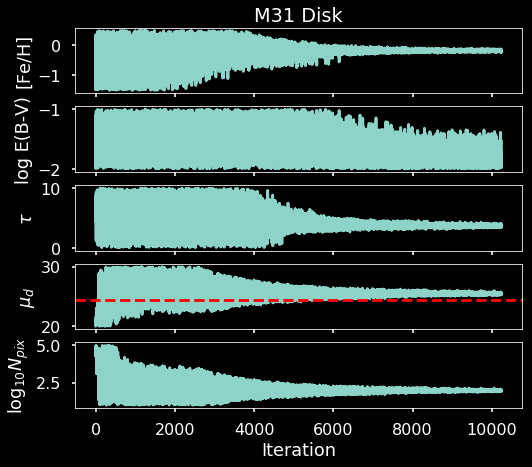

In [118]:
axes = res['m31_disk'].plot_chains(chains_only=True);
axes[3].axhline(y=24.47, ls='--', color='r')
plt.savefig(fig_dir + 'm31_disk_chains.jpg')

In [100]:
def plot_dmod(axes, dmod=24.47):
    i_dmod = 3
    for i, ax in enumerate(axes[0]):
        if 'mu' in ax.get_ylim():
            i_dmod = i
    for ax in axes[i_dmod, :i_dmod]:
        ax.axhline(y=24.42, ls='--', color='r')
    for ax in axes[i_dmod:, i_dmod]:
        ax.axvline(x=24.42, ls='--', color='r')

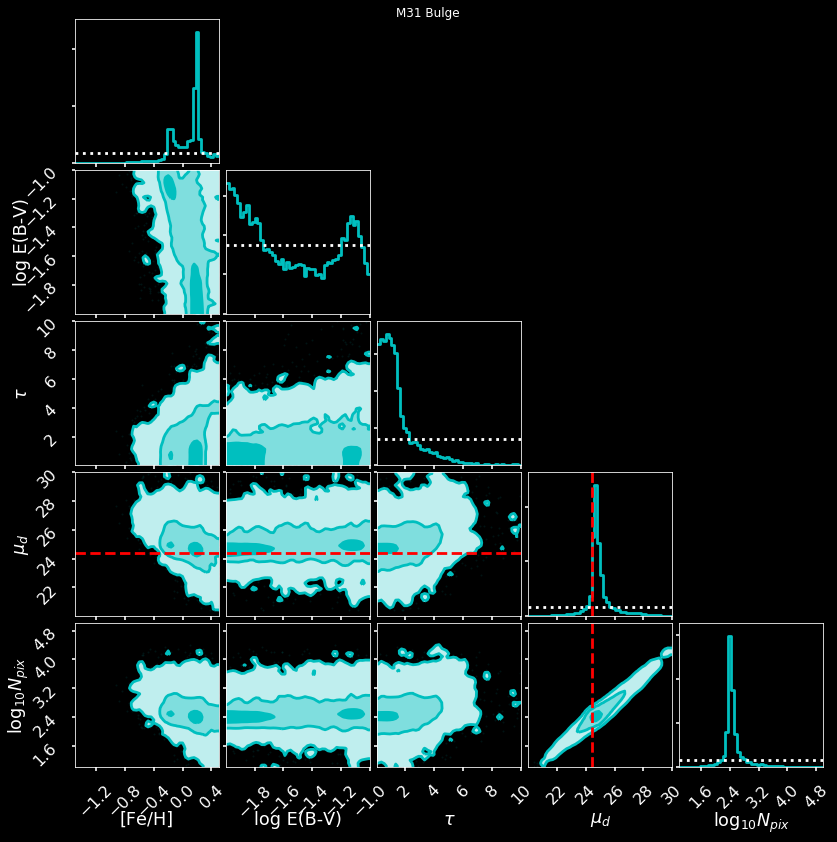

In [101]:
fig, axes = res['m31_bulge'].plot_corner(color='c', burn=2000, weight=False, bins=50, smooth_frac=0.02)
plot_dmod(axes)
plt.savefig(fig_dir + 'm31_bulge_corner.pdf')

In [128]:
mu_bulge = np.mean(res['m31_bulge'].df.dmod.tail(5000))
sig_bulge = np.std(res['m31_bulge'].df.dmod.tail(5000))

In [137]:
mu_disk = np.mean(res['m31_disk'].df.dmod.tail(5000))
sig_disk = np.std(res['m31_disk'].df.dmod.tail(5000))

In [126]:
dmod_to_mpc(24.47)

0.7834296427662114

In [133]:
np.mean(res['m31_bulge'].df.tau.tail(5000))

0.8756543239999973

In [134]:
np.mean(res['m31_disk'].df.tau.tail(5000))

3.8364178999999976

In [135]:
np.mean(res['m31_disk'].df.logfeh_mean.tail(5000))

-0.17972029243799983

In [136]:
np.std(res['m31_disk'].df.logfeh_mean.tail(5000))

0.05847969283573524

In [131]:
dmod_to_mpc(np.array([mu_bulge-sig_bulge, mu_bulge, mu_bulge+sig_bulge]))

array([0.80014124, 0.8774237 , 0.96217056])

In [132]:
dmod_to_mpc(np.array([mu_disk-sig_disk, mu_disk, mu_disk+sig_disk]))

array([1.07166671, 1.24692451, 1.45084353])

In [124]:
np.std(res['m31_bulge'].df.dmod.tail(5000))

0.20021352154577254

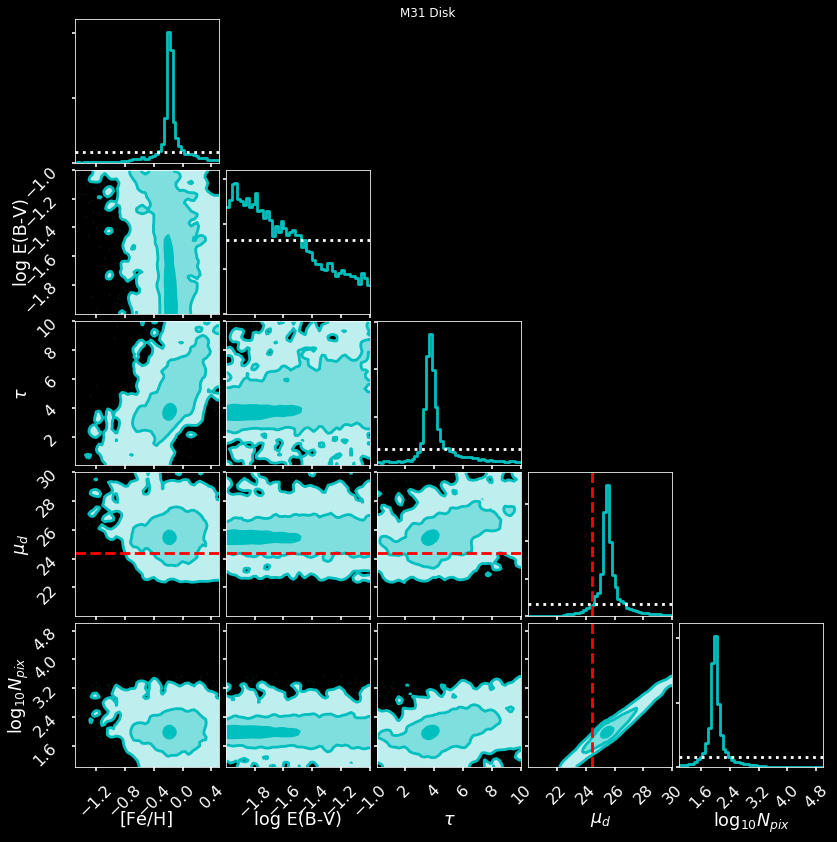

In [102]:
fig, axes = res['m31_disk'].plot_corner(color='c', burn=2000, weight=False, bins=50, smooth_frac=0.02)
plot_dmod(axes)
plt.savefig(fig_dir + 'm31_disk_corner.pdf')

In [88]:
def get_best_model(name):
    r = res[name]
    g = ppy.galaxy.TauFull()
    p = r.df.iloc[r.df.logl.idxmax()][['logfeh_mean', 'logdust', 'logNpix', 'tau', 'dmod']].values
    g.set_params(p)
    return g

In [89]:
g_bulge = get_best_model('m31_bulge')
g_disk = get_best_model('m31_disk')

In [90]:
g_bulge._params

array([ 0.18129, -1.8578 ,  2.4225 ,  0.22453, 24.683  ])

In [91]:
g_disk._params

array([-0.19446, -1.7377 ,  1.9821 ,  3.6604 , 25.481  ])

In [119]:
def dmod_to_mpc(dmod):
    return 10.**(0.2 * (dmod - 25.))

In [121]:
dmod_to_mpc(g_bulge._params[4]), dmod_to_mpc(g_disk._params[4])


(0.8641716206465504, 1.247958087870283)

In [92]:
sim_bulge = driv.simulate(g_bulge, 1024, mag_system='ab')[0]
sim_disk = driv.simulate(g_disk, 1024, mag_system='ab')[0]

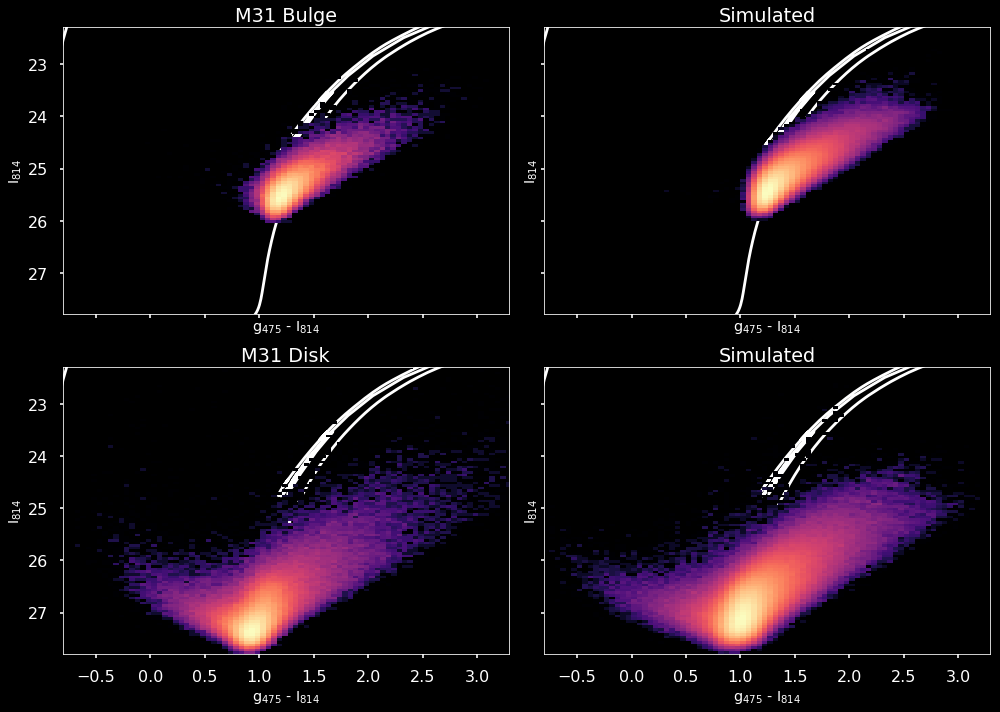

In [109]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 10), sharex=True, sharey=True)
ppy.plotting.plot_pcmd(m31_bulge, axes=axes[0,0], title='M31 Bulge', hist2d_kwargs={'cmap': 'magma'})
ppy.plotting.plot_pcmd(m31_disk, axes=axes[1,0], title='M31 Disk', hist2d_kwargs={'cmap': 'magma'})

ppy.plotting.plot_pcmd(sim_bulge, axes=axes[0,1], title='Simulated', hist2d_kwargs={'cmap': 'magma'})
ppy.plotting.plot_pcmd(sim_disk, axes=axes[1,1], title='Simulated', hist2d_kwargs={'cmap': 'magma'})

for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=24.47, mag_system='ab', axes=a, color='w', zorder=-1)
plt.tight_layout()
plt.savefig(fig_dir + 'm31_pcmds.pdf')